In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Introduction
Anomaly detection and anticipation is crucial in nowadays and future supercomputers.
- Previous works demonstrated that applying ML to data collected from computing nodes can lead to good results. 
- These approaches do not exploit any information contained in the **names** of the monitored metrics; this side info is implicit in the features of the dataset and it is naturally exploited by humans. 


# Introduction
- The idea of the project is to combine standard ML for time-series and NLP techniques to extract side-information into a single approach, and compare it with the current baseline for anomaly detection. 
- Our aim is to improve the ROC-AUC score of the model, while providing root-cause explainability on why and how NLP information help.
- The experiments will be done using data collected from Marconi100 supercomputer, hosted at CINECA.

## M100 time aggregated dataset
We used the time aggregated data collected from the nodes of the rack 0 of the M100[1] dataset. 
- Each node has a separate dataset.
- A dataset consists of aggregated metrics collected using the IPMI plugin, originally sampled every 20 seconds.
- Each metric/feature is aggregated in a time window of 15 minutes, described by the average, standard deviation, minimum and maximum.

## Metrics/ Features
|Metric|Description|Unit (ExaMon)|Unit (doc)|Value type|Sampling period|
|------|-----------|-------------|----------|----------|---------------|
|ambient|Temperature at the node inlet|degreesC|°C|float|20s (per node)|
|dimmX_temp|Temperature of DIMM module n. X. X=0..15|degreesC|°C|int|20s (per node)|
|fanX_Y|Speed of the Fan Y in module X. X=0..3, Y=0,1|revolutions|RPM|int|20s (per node)|
|fan_disk_power|Power consumption of the disk fan|Watts|W|int|20s (per node)|
|gpuX_core_temp|Temperature of the core for the GPU id X. X=0,1,3,4|degreesC|°C|int|20s (per node)|
|gpuX_mem_temp|Temperature of the memory for the GPU id X. X=0,1,3,4|degreesC|°C|int|20s (per node)|
|gv100cardX|X=0..3|unspecified||int|20s (per node)|
|pX_coreY_temp|Temperature of core n. Y in the CPU socket n. X. X=0..1, Y=0..23|degreesC|°C|int|20s (per node)|
|pX_io_power|Power consumption for the I/O subsystem for the CPU socket n. X. X=0..1|Watts|W|int|20s (per node)|
|pX_mem_power|Power consumption for the memory subsystem for the CPU socket n. X. X=0..1|Watts|W|int|20s (per node)|
|pX_power|Power consumption for the CPU socket n. X. X=0..1|Watts|W|int|20s (per node)|
|pX_vdd_temp|Temperature of the voltage regulator for the CPU socket n. X. X=0..1|degreesC|°C|int|20s (per node)|
|pcie|Temperature at the PCIExpress slots|degreesC|°C|float|20s (per node)|
|psX_input_power|Power consumption at the input of power supply n. X. X=0..1|Watts|W|int|20s (per node)|
|psX_input_voltag|Voltage at the input of power supply n. X. X=0..1|Volts|V|int|20s (per node)|
|psX_output_curre|Current at the output of power supply n. X. X=0..1|Amps|A|int|20s (per node)|
|psX_output_volta|Voltage at the output of power supply n. X. X=0..1|Volts|V|float|20s (per node)|
|total_power|Total node power consumption|Watts|W|int|20s (per node)|


In [3]:
from torch.utils.data import Dataset
from pathlib import Path
import pandas as pd
import numpy as np
from src.utils.general import create_time_aggregated_descriptions_dict
from sklearn.preprocessing import MinMaxScaler


class TimeAggregatedNode(Dataset):
    def __init__(self, root_path: str, descriptions_path: str, window_size: int = 20, split: str = "train"):
        self.root_path = Path(root_path)
        self.descriptions_path = Path(descriptions_path)
        self.window_size = window_size
        self.split = split

        data = pd.read_parquet(root_path)
        descriptions = pd.read_csv(self.descriptions_path, names=["name", "description"])
        self.descriptions, self.group_dict = create_time_aggregated_descriptions_dict(data, dict(descriptions.values))

        # Dropping missing values and data normalization in [0, 1]
        data = data.dropna()
        data = data.reset_index(drop=True)

        train_split_idx = int(len(data) * 0.7)
        val_split_idx = int(len(data) * 0.8)
        scaler = MinMaxScaler((0, 1))
        scaler.fit(data.iloc[:train_split_idx].drop(["timestamp", "value"], axis=1).values)

        if self.split == "train":
            data = data.iloc[:train_split_idx].reset_index(drop=True)
        elif self.split == "val":
            data = data.iloc[train_split_idx:val_split_idx].reset_index(drop=True)
        elif self.split == "test":
            data = data.iloc[val_split_idx:].reset_index(drop=True)

        self.data, self.timeseries_list = self.preprocess_data(data, scaler)

        windows_cumsum = np.array([timeseries.shape[0] - window_size - 1 for timeseries in self.timeseries_list] + [0])
        windows_cumsum = np.cumsum(windows_cumsum)
        windows_cumsum[-1] = 0
        self.windows_cumsum = windows_cumsum

    def preprocess_data(self, data: pd.DataFrame, scaler: MinMaxScaler):
        data.loc[:, ~data.columns.isin(["timestamp", "value"])] = scaler.transform(data.drop(["timestamp", "value"], axis=1).values)
        if self.split == "train":
            data = data.loc[~(data["value"] > 0)].reset_index(drop=True)
        # Partition the timeseries in subseries without time gaps bigger than 15 minutes
        diffs = dict(data["timestamp"].diff().apply(lambda x: x / np.timedelta64(1, "m")).fillna(0).astype("int64"))
        large_diffs = {i: diffs[i] for i in diffs.keys() if diffs[i] > 15}
        lk = [0] + list(large_diffs.keys()) + [data.shape[0] + 1]
        timeseries_list = [data.iloc[lk[n] : lk[n + 1]].drop("timestamp", axis=1) for n in range(len(lk) - 1)]
        timeseries_list = [i for i in timeseries_list if i.shape[0] > self.window_size]

        return data, timeseries_list

    def __len__(self):
        return self.windows_cumsum[-2]

    def __getitem__(self, idx):
        assert idx >= 0
        for i in range(len(self.timeseries_list)):
            if idx < self.windows_cumsum[i]:
                timeseries = self.timeseries_list[i]
                window_start_idx = idx - self.windows_cumsum[i - 1]
                window = timeseries.iloc[window_start_idx : window_start_idx + self.window_size].to_numpy(np.float32)
                x, y, l = window[:, :-1], window[-1, :-1], window[-1, -1]
                return x, y, l
        raise RuntimeError("Index out of range")

## RUAD (Recurrent Unsupervised Anomaly Detection)

![ruad](res/ruad.png)

**RUAD** [2] is a model for anomaly detection in HPC systems.
- It is an autoencoder with an encoder with recurrent layers and a dense decoder.
- Given a time step $t_0$ and a window size $W$, to reconstruct a vector $x_{t_0}$ it takes as input a sequence $x_{t_0 - W + 1}, ..., x_{t_0}$, that is sequence of vectors observed in the current time window $W$.


## RUAD (Recurrent Unsupervised Anomaly Detection)

![ruad](res/ruad.png)

- Its reconstruction error can be used as a signal to detect anomalies.
- We will use RUAD as our baseline for the experiments, trying to improve its ROC-AUC on the test set of each single node in the rack 0.


## M100 time aggregated dataset
Let's have a look at the data collected from node 17.

In [4]:
data = pd.read_parquet("data/time-aggregated/17.parquet")
data.head()

,timestamp,ambient_avg,ambient_std,ambient_min,ambient_max,dimm0_temp_avg,dimm0_temp_std,dimm0_temp_min,dimm0_temp_max,dimm10_temp_avg,...,ps1_output_curre_max,ps1_output_volta_avg,ps1_output_volta_std,ps1_output_volta_min,ps1_output_volta_max,total_power_avg,total_power_std,total_power_min,total_power_max,value
0,2020-03-09 12:00:00+00:00,23.400002,0.000000,23.4,23.4,30.0,0.0,30.0,30.0,31.0,...,21.0,12.379999,0.040000,12.3,12.4,399.428571,3.331973,380.0,400.0,<NA>
1,2020-03-09 12:15:00+00:00,23.418751,0.058296,23.4,23.6,30.0,0.0,30.0,30.0,31.0,...,21.0,12.378124,0.041340,12.3,12.4,399.375000,3.479853,380.0,400.0,<NA>
2,2020-03-09 12:30:00+00:00,23.405558,0.032867,23.4,23.6,30.0,0.0,30.0,30.0,31.0,...,21.0,12.377777,0.041574,12.3,12.4,400.000000,0.000000,400.0,400.0,<NA>
3,2020-03-09 12:45:00+00:00,23.447368,0.085029,23.4,23.6,30.0,0.0,30.0,30.0,31.0,...,21.0,12.378946,0.040768,12.3,12.4,400.000000,0.000000,400.0,400.0,<NA>
4,2020-03-09 13:00:00+00:00,23.417779,0.056917,23.4,23.6,30.0,0.0,30.0,30.0,31.0,...,21.0,12.384446,0.036243,12.3,12.4,399.111111,4.121608,380.0,400.0,<NA>


## M100 time aggregated dataset
Let's drop every row with missing values.

In [5]:
data_na = data.dropna()
data_na = data_na.reset_index(drop=True)
data_na.head()

,timestamp,ambient_avg,ambient_std,ambient_min,ambient_max,dimm0_temp_avg,dimm0_temp_std,dimm0_temp_min,dimm0_temp_max,dimm10_temp_avg,...,ps1_output_curre_max,ps1_output_volta_avg,ps1_output_volta_std,ps1_output_volta_min,ps1_output_volta_max,total_power_avg,total_power_std,total_power_min,total_power_max,value
0,2020-05-11 14:45:00+00:00,21.907693,0.099704,21.799999,22.000000,29.0,0.0,29.0,29.0,29.000,...,21.0,12.387178,0.033432,12.3,12.4,396.410256,7.675195,380.0,400.0,0
1,2020-05-11 17:45:00+00:00,21.953848,0.084265,21.799999,22.000000,29.0,0.0,29.0,29.0,29.000,...,21.0,12.376924,0.042132,12.3,12.4,395.384615,8.426501,380.0,400.0,0
2,2020-05-11 18:00:00+00:00,22.000000,0.000000,22.000000,22.000000,29.0,0.0,29.0,29.0,29.000,...,21.0,12.380488,0.039629,12.3,12.4,397.560976,6.544589,380.0,400.0,0
3,2020-05-11 18:15:00+00:00,22.126828,0.096334,22.000000,22.200001,29.0,0.0,29.0,29.0,29.000,...,21.0,12.368292,0.046533,12.3,12.4,399.024390,4.308176,380.0,400.0,0
4,2020-05-11 18:30:00+00:00,22.215001,0.052678,22.200001,22.400000,29.0,0.0,29.0,29.0,29.875,...,22.0,12.375000,0.043301,12.3,12.4,397.000000,7.141428,380.0,400.0,0


## M100 time aggregated dataset
RUAD expects as input a sequence of feature vectors of length $W$.
- Elements belonging to the same window should be distant 15 minutes from each other
- The raw timeseries presents gaps in the data.
- To drop missing values creates gaps in the data that are larger than 15 minutes.

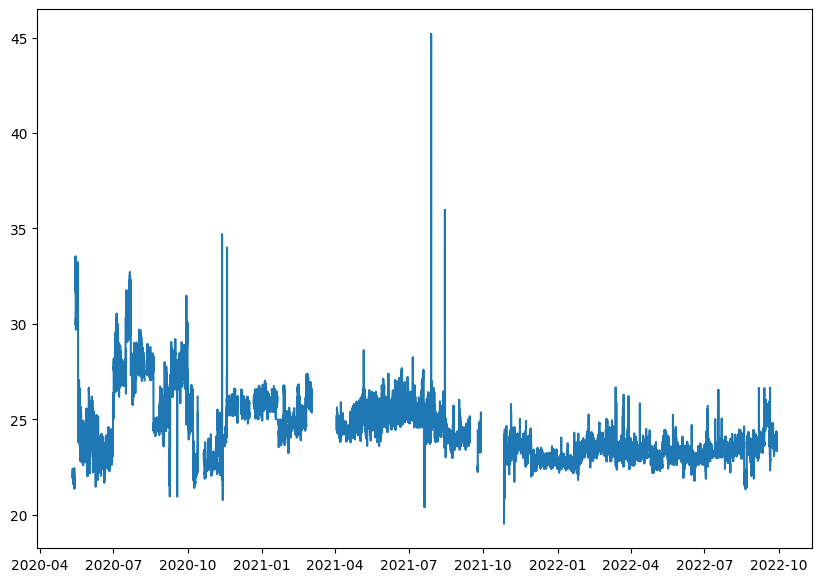

In [99]:
import matplotlib.pyplot as plt

tot_timestamp = pd.date_range(start=data.timestamp[0], end=data.timestamp[len(data) - 1], freq=pd.offsets.Minute(15))
data_fill = data_na.set_index(data_na.timestamp).reindex(pd.DatetimeIndex(tot_timestamp), fill_value=np.nan)
plt.figure(figsize=(10, 7))
plt.plot(tot_timestamp, data_fill.ambient_avg.to_numpy(np.float32, na_value=np.nan))
plt.show()

## M100 time aggregated dataset
Let's scale each feature in [0, 1] independently

In [6]:
train_split_idx = int(len(data_na) * 0.8)
scaler = MinMaxScaler((0, 1))
scaler.fit(data_na.iloc[:train_split_idx].drop(["timestamp", "value"], axis=1).values)
data_na.loc[:, ~data_na.columns.isin(["timestamp", "value"])] = scaler.transform(data_na.drop(["timestamp", "value"], axis=1).values)
data_na.head()

,timestamp,ambient_avg,ambient_std,ambient_min,ambient_max,dimm0_temp_avg,dimm0_temp_std,dimm0_temp_min,dimm0_temp_max,dimm10_temp_avg,...,ps1_output_curre_max,ps1_output_volta_avg,ps1_output_volta_std,ps1_output_volta_min,ps1_output_volta_max,total_power_avg,total_power_std,total_power_min,total_power_max,value
0,2020-05-11 14:45:00+00:00,0.092806,0.029481,0.123967,0.070922,0.139752,0.0,0.15,0.125,0.072776,...,0.318182,0.998966,0.005456,0.991936,1.0,0.055270,0.017558,0.142857,0.034483,0
1,2020-05-11 17:45:00+00:00,0.094603,0.024916,0.123967,0.070922,0.139752,0.0,0.15,0.125,0.072776,...,0.318182,0.998139,0.006876,0.991936,1.0,0.053733,0.019276,0.142857,0.034483,0
2,2020-05-11 18:00:00+00:00,0.096400,0.000000,0.132231,0.070922,0.139752,0.0,0.15,0.125,0.072776,...,0.318182,0.998426,0.006467,0.991936,1.0,0.056993,0.014971,0.142857,0.034483,0
3,2020-05-11 18:15:00+00:00,0.101339,0.028485,0.132231,0.078014,0.139752,0.0,0.15,0.125,0.072776,...,0.318182,0.997443,0.007594,0.991936,1.0,0.059186,0.009855,0.142857,0.034483,0
4,2020-05-11 18:30:00+00:00,0.104773,0.015576,0.140496,0.085106,0.139752,0.0,0.15,0.125,0.115229,...,0.333333,0.997984,0.007066,0.991936,1.0,0.056153,0.016337,0.142857,0.034483,0


## M100 time aggregated dataset
We need to sample windows of rows from the timeseries so that there are no gaps larger than 15 minutes between them.

In [102]:
window_size = 10
diffs = dict(data_na["timestamp"].diff().apply(lambda x: x / np.timedelta64(1, "m")).fillna(0).astype("int64"))
large_diffs = {i: diffs[i] for i in diffs.keys() if diffs[i] > 15}
lk = [0] + list(large_diffs.keys()) + [data_na.shape[0] + 1]
timeseries_list = [data_na.iloc[lk[n] : lk[n + 1]].drop("timestamp", axis=1) for n in range(len(lk) - 1)]
timeseries_list = [i for i in timeseries_list if i.shape[0] > window_size]

In [110]:
window_start_idx = 5
window = timeseries_list[0].iloc[window_start_idx : window_start_idx + window_size]
window

,ambient_avg,ambient_std,ambient_min,ambient_max,dimm0_temp_avg,dimm0_temp_std,dimm0_temp_min,dimm0_temp_max,dimm10_temp_avg,dimm10_temp_std,...,ps1_output_curre_max,ps1_output_volta_avg,ps1_output_volta_std,ps1_output_volta_min,ps1_output_volta_max,total_power_avg,total_power_std,total_power_min,total_power_max,value
6,0.107673,0.029404,0.140496,0.085106,0.139752,0.0,0.15,0.125,0.121294,0.000000,...,0.333333,0.998302,0.006653,0.991936,1.0,0.058282,0.012337,0.142857,0.034483,0
7,0.105301,0.020694,0.140496,0.085106,0.139752,0.0,0.15,0.125,0.118983,0.084134,...,0.318182,0.997120,0.007819,0.991936,1.0,0.059934,0.012179,0.142857,0.051724,0
8,0.111392,0.015576,0.140496,0.085106,0.139752,0.0,0.15,0.125,0.121294,0.000000,...,0.318182,0.997984,0.007066,0.991936,1.0,0.057651,0.013726,0.142857,0.034483,0
9,0.111049,0.019151,0.140496,0.085106,0.139752,0.0,0.15,0.125,0.121294,0.000000,...,0.318182,0.997120,0.007819,0.991936,1.0,0.057080,0.014816,0.142857,0.034483,0
10,0.111252,0.017177,0.140496,0.085106,0.139752,0.0,0.15,0.125,0.121294,0.000000,...,0.318182,0.997937,0.007120,0.991936,1.0,0.057860,0.013289,0.142857,0.034483,0
11,0.111787,0.009122,0.140496,0.085106,0.139752,0.0,0.15,0.125,0.121294,0.000000,...,0.318182,0.998230,0.006755,0.991936,1.0,0.059186,0.009855,0.142857,0.034483,0
12,0.108557,0.029348,0.140496,0.085106,0.139752,0.0,0.15,0.125,0.121294,0.000000,...,0.318182,0.998033,0.007008,0.991936,1.0,0.056993,0.014971,0.142857,0.034483,0
13,0.111772,0.009466,0.140496,0.085106,0.139752,0.0,0.15,0.125,0.121294,0.000000,...,0.318182,0.997878,0.007186,0.991936,1.0,0.059859,0.007324,0.142857,0.034483,0
14,0.111977,0.000000,0.148760,0.085106,0.139752,0.0,0.15,0.125,0.121294,0.000000,...,0.318182,0.998848,0.005710,0.991936,1.0,0.058507,0.015444,0.142857,0.051724,0
15,0.111977,0.000000,0.148760,0.085106,0.139752,0.0,0.15,0.125,0.121294,0.000000,...,0.318182,0.998272,0.006696,0.991936,1.0,0.059934,0.018646,0.142857,0.068966,0


## RUAD PyTorch/Lightning implementation

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RUAD(nn.Module):
    def __init__(self, input_size) -> None:
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, 16, batch_first=True)
        self.lstm2 = nn.LSTM(16, 16, batch_first=True)
        self.lstm3 = nn.LSTM(16, 8, batch_first=True)

        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, input_size)

    def forward(self, x):
        x = F.selu(self.lstm1(x)[0])
        x = F.selu(self.lstm2(x)[0])
        x = F.selu(self.lstm3(x)[0])

        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
### RUAD baseline
from lightning.pytorch.utilities.types import OptimizerLRScheduler
import lightning as L
from torch.optim import Adam, RMSprop
from torchmetrics import CatMetric
from torchmetrics.functional import auroc


class RUADModule(L.LightningModule):
    def __init__(self, model: nn.Module, lr: float, optimizer: str = "adam") -> None:
        super().__init__()
        self.lr = lr
        self.model = model
        self.loss_fn = nn.MSELoss()

        self.all_targets = CatMetric()
        self.all_labels = CatMetric()
        self.all_preds = CatMetric()
        self.optimizer = optimizer

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        inputs, targets, _ = batch
        preds = self.model(inputs)
        # loss = self.loss_fn(preds, targets)
        loss = self.loss_fn(preds, inputs)
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_loss_step", loss, on_step=True)
        return loss

    def validation_step(self, batch, _):
        inputs, targets, labels = batch
        preds = self.model(inputs)
        loss = self.loss_fn(preds, inputs)

        self.all_preds.update(preds)
        self.all_targets.update(targets)
        self.all_labels.update(labels)
        self.log("val_loss", loss, on_epoch=True)

    def on_validation_epoch_end(self) -> None:
        preds, targets, labels = self.all_preds.compute(), self.all_targets.compute(), self.all_labels.compute()
        reconstruction_error = torch.abs(targets - preds[:, -1]).sum(-1)
        unthresholded_response = reconstruction_error / (reconstruction_error.max() + 1e-16)
        labels[labels > 0] = 1
        roc_auc = auroc(unthresholded_response, labels.int(), task="binary")
        self.log("roc_auc", roc_auc, on_epoch=True)

        self.all_preds.reset()
        self.all_targets.reset()
        self.all_labels.reset()

    def test_step(self, batch, _):
        return self.validation_step(batch, None)

    def on_test_epoch_end(self) -> None:
        return self.on_validation_epoch_end()

    def configure_optimizers(self) -> OptimizerLRScheduler:
        optim_cls = None
        if self.optimizer == "adam":
            optim_cls = Adam
        elif self.optimizer == "rmsprop":
            optim_cls = RMSprop
        else:
            raise RuntimeError("Unsupported optimizer")
        return optim_cls(self.model.parameters(), lr=self.lr)

/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training scripts and helpers

In [6]:
### TRAINING
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import random
from pathlib import Path


def train(model, train_loader, val_loader, num_epochs=5, name="RUAD"):
    callbacks = []
    callbacks.append(ModelCheckpoint(filename="best", monitor="roc_auc", mode="max"))

    logger = TensorBoardLogger(save_dir="runs/", name=name)

    trainer = L.Trainer(max_epochs=num_epochs, callbacks=callbacks, logger=logger)
    trainer.fit(model, train_loader, val_loader)


def batch_collator(batch, features_idx=None):
    inputs, targets = [torch.tensor(b[0]) for b in batch], [torch.tensor(b[1]) for b in batch]
    labels = [torch.tensor(b[2]) for b in batch]
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    labels = torch.stack(labels)
    if features_idx:
        inputs, targets = inputs[..., features_idx], targets[..., features_idx]
    return inputs, targets, labels


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


root_path = Path("data/time-aggregated/")
seed = 42
num_features = 352
window_size = 10
batch_size = 128
num_workers = 8
lr = 1e-4
rack_0 = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19]

## RUAD baseline training: node 17 example
We are going to train RUAD on the aggregated data obtained from node 17. 
We found the following as good hyperparameters choices:
- learning rate: 1e-4,
- window size: 10 
- batch size: 128

### RUAD Node 17 training

In [ ]:
set_seed(seed)
node = 17
file_path = root_path / f"{node}.parquet"
train_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="train", window_size=window_size)
val_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="val", window_size=window_size)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=batch_collator,
    shuffle=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=batch_collator,
)

model = RUADModule(RUAD(num_features), lr=lr, optimizer="adam")
train(model, train_loader, val_loader, name=f"lr{lr}/RUAD_{node}", num_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 33.1 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
33.1 K    Trainable params
0         Non-trainable params
33.1 K    Total params
0.132     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:23<00:00, 19.00it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:23<00:00, 18.99it/s, v_num=1]


### RUAD Node 17 results on test set

In [ ]:
model = RUADModule.load_from_checkpoint(f"runs/lr{lr}/RUAD_{node}/version_0/checkpoints/best.ckpt", model=RUAD(num_features), lr=lr)
test_dataset = TimeAggregatedNode(
    root_path=root_path / f"{node}.parquet", descriptions_path="descriptions.csv", split="test", window_size=window_size
)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=batch_collator)
L.Trainer().test(model, test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 114/114 [00:03<00:00, 33.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         roc_auc            0.7780559659004211
        val_loss           0.0017428293358534575
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.0017428293358534575, 'roc_auc': 0.7780559659004211}]

## RUAD baseline training: all nodes from rack 0

### RUAD Rack 0 training

In [ ]:
for node in rack_0:
    set_seed(seed)
    file_path = root_path / f"{node}.parquet"

    train_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="train", window_size=window_size)
    val_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="val", window_size=window_size)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator,
        shuffle=True,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator,
    )

    model = RUADModule(RUAD(num_features), lr=lr, optimizer="adam")
    train(model, train_loader, val_loader, name=f"lr{lr}/RUAD_{node}", num_epochs=10)

### RUAD Rack 0 test

In [10]:
trainer = L.Trainer()
results_baseline = {}
for node in rack_0:
    model = RUADModule.load_from_checkpoint(f"runs/lr{lr}/RUAD_{node}/version_0/checkpoints/best.ckpt", model=RUAD(num_features), lr=lr)
    test_dataset = TimeAggregatedNode(
        root_path=root_path / f"{node}.parquet", descriptions_path="descriptions.csv", split="test", window_size=window_size
    )
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=batch_collator)
    roc_auc = trainer.test(model, test_loader, verbose=False)[0]["roc_auc"]
    results_baseline[node] = roc_auc

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 111/111 [00:03<00:00, 33.52it/s]


## Rack 0 ROC-AUC scores

In [ ]:
avg_roc_auc = sum(results_baseline.values()) / len(results_baseline)
print("Average ROC-AUC:", avg_roc_auc)
for k in results_baseline.keys():
    print(f"Node {k} ROC-AUC:", results_baseline[k])

Average ROC-AUC: 0.6759323179721832
Node 2 ROC-AUC: 0.5566859841346741
Node 3 ROC-AUC: 0.5441418886184692
Node 4 ROC-AUC: 0.7338272929191589
Node 5 ROC-AUC: 0.6134512424468994
Node 6 ROC-AUC: 0.517902135848999
Node 7 ROC-AUC: 0.7805595397949219
Node 8 ROC-AUC: 0.7735768556594849
Node 9 ROC-AUC: 0.597144365310669
Node 10 ROC-AUC: 0.7493579387664795
Node 11 ROC-AUC: 0.7226936221122742
Node 13 ROC-AUC: 0.7484632730484009
Node 14 ROC-AUC: 0.7526764273643494
Node 16 ROC-AUC: 0.7027846574783325
Node 17 ROC-AUC: 0.7780559659004211
Node 18 ROC-AUC: 0.6984520554542542
Node 19 ROC-AUC: 0.5451438426971436


## Sentence embeddings extraction with MiniLM
We need to associate a proper textual description to each metric, then extract a neural representation from it.
- We use the metrics description found on the M100 documentation as textual representation.
- We replace X and Y variables with the proper number.
    - e.g. dimm1_temp -> "Temperature of DIMM module n. **one**."
- We prepend "Average/Standard deviation of/Minimum/Maximum" to the proper aggregated metric.
    - e.g. ambient_avg -> "**Average** temperature at the node inlet."

|Metric|Description|Unit (ExaMon)|Unit (doc)|Value type|Sampling period|
|------|-----------|-------------|----------|----------|---------------|
|ambient|Temperature at the node inlet|degreesC|°C|float|20s (per node)|
|dimmX_temp|Temperature of DIMM module n. X. X=0..15|degreesC|°C|int|20s (per node)|
|fanX_Y|Speed of the Fan Y in module X. X=0..3, Y=0,1|revolutions|RPM|int|20s (per node)|


## Sentence embeddings extraction with MiniLM
To extract a neural representation from the description, we use **MiniLM** [3]
- It is a Transformer-bases LM trained with knowledge distillation on BERT [4].
- It can be used for various downstream NLP tasks, including **sentence embeddings** extraction.
- We used MiniLM to extract sentence embeddings from the textual descriptions.


In [7]:
from num2words import num2words
import re
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
dataset = TimeAggregatedNode(
    root_path="data/time-aggregated/17.parquet", descriptions_path="descriptions.csv", split="train", window_size=window_size
)


def convert_numbers_to_words(descriptions):
    new_descriptions = []
    for desc in descriptions:
        match = re.findall("[0-9]+", desc)
        spelled_nums = [num2words(num) for num in match]
        for num in spelled_nums:
            desc = re.sub("[0-9]+", num, desc)
        new_descriptions.append(desc)
    return new_descriptions


descriptions = dataset.descriptions.values()
descriptions = convert_numbers_to_words(descriptions)

encoded_descriptions = [tokenizer(desc, return_tensors="pt") for desc in descriptions]
model.eval()
with torch.no_grad():
    sentence_embeddings = [model(**encoded_desc).pooler_output for encoded_desc in encoded_descriptions]
    sentence_embeddings = torch.cat(sentence_embeddings)

/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Embedding reduction and visualization with TSNE
To have a sense of how embeddings are semantically represented, we reduced their dimension to 2 with TSNE

In [6]:
tsne = TSNE(n_components=2, n_iter=10000, perplexity=10)
reduced_embeddings = tsne.fit_transform(sentence_embeddings)

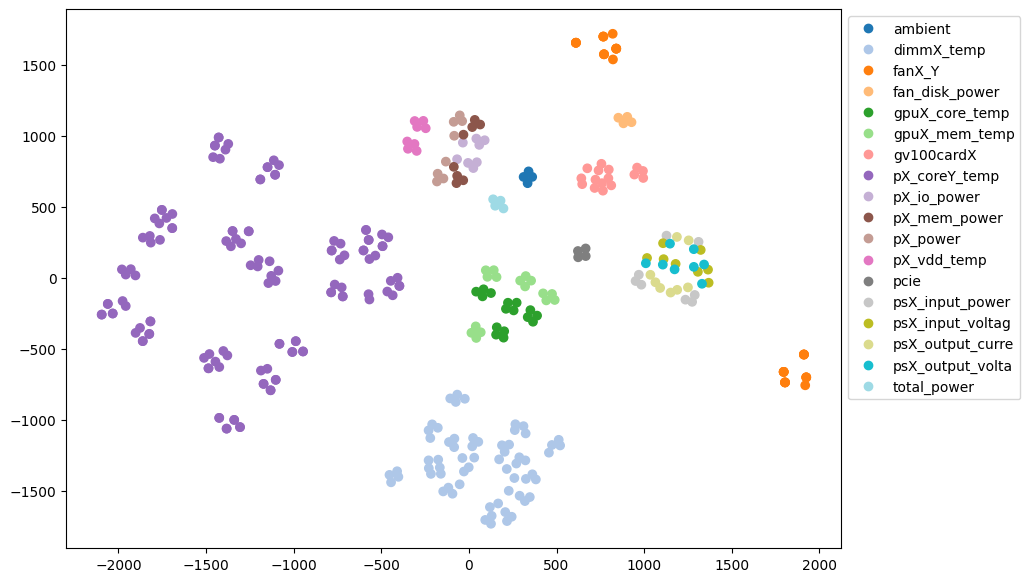

In [8]:
descriptions_csv = pd.read_csv("descriptions.csv", names=["name", "description"])
fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=np.array(list(dataset.group_dict.values())), cmap="tab20")
labels = [desc for desc in descriptions_csv["name"]]
ax.legend(scatter.legend_elements(num=18)[0], labels, bbox_to_anchor=(1, 1))

## RUAD with feature gating
To merge the two kind of approaches(RUAD and NLP) while enabling root-cause explainability, one of the simplest and natural techniques is **gating**.
- We will gate the feature vector entries based on the corresponding sentence embedding.
- The network can learn to weight each feature according to its description meaning.
- The model has then the power to learn if a feature is important or not to be reconstructed also according to its textual representation.

## RUAD with feature gating
- The model linearly projects each single embedding to a space of dimension 1
- The output is processed by a gating function and the resulting value is multiplied/fused with the feature vector.

It supports the following gating mechanisms:
- sigmoid
- softmax
- tanh
- Gated Bimodal Unit (from Gated Multimodal Unit [5])

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial


class GatedBimodalUnit(nn.Module):
    def __init__(self, output_dim) -> None:
        super().__init__()
        self.output_dim = output_dim
        self.wz1 = nn.Linear(output_dim, output_dim, bias=False)
        self.wz2 = nn.Linear(output_dim, output_dim, bias=False)
        self.bz = nn.Parameter(torch.nn.init.uniform_(torch.empty((output_dim))))

    def forward(self, x1, x2):
        h1 = F.tanh(x1)
        h2 = F.tanh(x2)
        z = F.sigmoid(self.wz1(x1) + self.wz2(x2) + self.bz)
        return torch.multiply(z, h1) + torch.multiply(1 - z, h2)

In [9]:
class RUADWithGating(nn.Module):
    def __init__(self, description_embeddings, gating="sigmoid") -> None:
        super().__init__()
        if type(description_embeddings) == torch.Tensor:
            self.description_embeddings = description_embeddings
            self.description_embeddings.requires_grad = False
            self.input_size = description_embeddings.shape[0]
            self.embedding_space = description_embeddings.shape[1]
        elif type(description_embeddings) == tuple:
            self.input_size = description_embeddings[0]
            self.embedding_space = description_embeddings[1]
            self.description_embeddings = nn.Parameter(torch.nn.init.uniform_(torch.empty((self.input_size, self.embedding_space))))

        self.gating = gating
        self.mask_fc = nn.Linear(self.embedding_space, 1)
        self.ruad = RUAD(input_size=self.input_size)

        if gating == "sigmoid":
            self.gating_fn = F.sigmoid
        elif gating == "softmax":
            self.gating_fn = partial(F.softmax, dim=-1)
        elif gating == "tanh":
            self.gating_fn = F.tanh
        elif gating == "gbu":
            self.gating_fn = GatedBimodalUnit(self.input_size)
        else:
            raise RuntimeError("Unsupported gating function.")

    def forward(self, x):
        if self.gating == "gbu":
            x = self.gating_fn(x, self.mask_fc(self.description_embeddings).squeeze(-1))
        else:
            gate = self.gating_fn(self.mask_fc(self.description_embeddings).squeeze(-1))
            x = torch.multiply(x, gate)
        x = self.ruad(x)
        return x

## RUAD with gating training on node 17

In [ ]:
node = 17
file_path = root_path / f"{node}.parquet"

for gating in ["sigmoid", "tanh", "softmax", "gbu"]:
    set_seed(seed)
    train_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="train", window_size=window_size)
    val_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="val", window_size=window_size)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator,
        shuffle=True,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator,
    )

    model = RUADModule(RUADWithGating(sentence_embeddings, gating=gating), lr=lr, optimizer="adam")
    train(model, train_loader, val_loader, name=f"lr{lr}/RUAD_{gating}_{node}", num_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:32<00:00, 13.54it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:32<00:00, 13.53it/s, v_num=1]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:22<00:00, 19.53it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:22<00:00, 19.53it/s, v_num=1]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_17

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:21<00:00, 20.07it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:21<00:00, 20.07it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_gbu_17

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 281 K 
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
281 K     Trainable params
0         Non-trainable params
281 K     Total params
1.127     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:28<00:00, 15.47it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:28<00:00, 15.47it/s, v_num=0]


## RUAD with gating test on node 17

In [ ]:
models = {}
for gating in ["sigmoid", "tanh", "softmax", "gbu"]:
    model = RUADModule.load_from_checkpoint(
        f"runs/lr{lr}/RUAD_{gating}_{node}/version_0/checkpoints/best.ckpt",
        model=RUADWithGating(sentence_embeddings, gating=gating),
        lr=lr,
    )
    models[gating] = model
models["base"] = RUADModule.load_from_checkpoint(
    f"runs/lr{lr}/RUAD_{node}/version_0/checkpoints/best.ckpt", model=RUAD(num_features), lr=lr
)

In [ ]:
trainer = L.Trainer()
results = {}
for model_name in models.keys():
    model = models[model_name]
    test_dataset = TimeAggregatedNode(
        root_path=root_path / f"{node}.parquet", descriptions_path="descriptions.csv", split="test", window_size=window_size
    )
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=batch_collator)
    roc_auc = trainer.test(model, test_loader, verbose=False)[0]["roc_auc"]
    results[model_name] = roc_auc

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 114/114 [00:03<00:00, 36.30it/s]


## RUAD with gating improvement w.r.t. baseline

In [ ]:
base_roc = results["base"]
for gating in ["softmax", "sigmoid", "tanh", "gbu"]:
    roc_improvement = results[gating] - base_roc
    print(f"ROC-AUC improvement of RUAD with '{gating}':", roc_improvement)

ROC-AUC improvement of RUAD with 'softmax': 0.011882543563842773
ROC-AUC improvement of RUAD with 'sigmoid': -0.006603717803955078
ROC-AUC improvement of RUAD with 'tanh': -0.01731640100479126
ROC-AUC improvement of RUAD with 'gbu': -0.0062670111656188965


## RUAD with gating: gate output inspection

In [ ]:
gates = {}
with torch.no_grad():
    for gating in ["softmax", "sigmoid"]:
        model = models[gating]
        model.eval()
        embeddings = model.model.description_embeddings
        mask_fc = model.model.mask_fc
        gate = model.model.gating_fn(mask_fc(embeddings).squeeze(-1))
        gates[gating] = gate

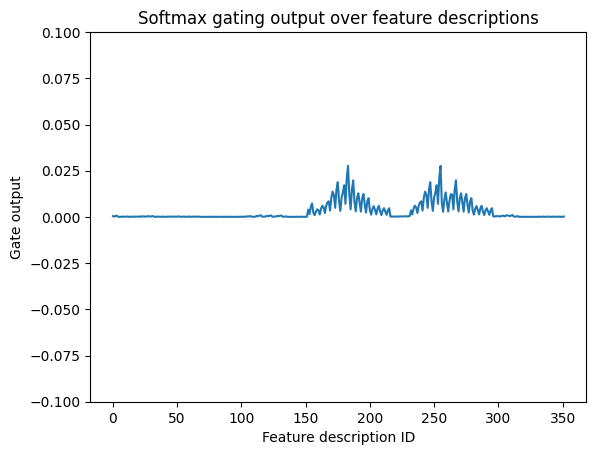

In [ ]:
plt.plot(np.arange(352), gates["softmax"].detach())
plt.ylim((-0.1, 0.1))
plt.title("Softmax gating output over feature descriptions")
plt.ylabel("Gate output")
plt.xlabel("Feature description ID")

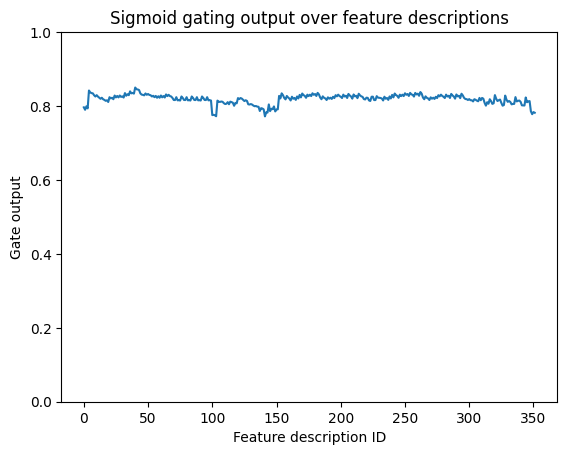

In [ ]:
plt.plot(np.arange(352), gates["sigmoid"].detach())
plt.ylim((0, 1))
plt.title("Sigmoid gating output over feature descriptions")
plt.ylabel("Gate output")
plt.xlabel("Feature description ID")

## RUAD with softmax gating training: all nodes from rack 0

In [11]:
for node in rack_0:
    set_seed(seed)
    file_path = root_path / f"{node}.parquet"
    train_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="train", window_size=window_size)
    val_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="val", window_size=window_size)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator,
        shuffle=True,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator,
    )

    model = RUADModule(RUADWithGating(sentence_embeddings, gating="softmax"), lr=lr, optimizer="adam")
    train(model, train_loader, val_loader, name=f"lr{lr}/RUAD_softmax_{node}", num_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_2

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 376/376 [00:18<00:00, 20.29it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 376/376 [00:18<00:00, 20.29it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_3

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 98/98 [00:07<00:00, 13.64it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 98/98 [00:07<00:00, 13.62it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_4

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 153/153 [00:09<00:00, 16.23it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 153/153 [00:09<00:00, 16.22it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_5

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 154/154 [00:09<00:00, 16.18it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 154/154 [00:09<00:00, 16.17it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_6

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 160/160 [00:09<00:00, 17.35it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 160/160 [00:09<00:00, 17.34it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_7

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 436/436 [00:24<00:00, 17.49it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 436/436 [00:24<00:00, 17.48it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_8

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 436/436 [00:20<00:00, 21.64it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 436/436 [00:20<00:00, 21.61it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_9

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:22<00:00, 19.98it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:22<00:00, 19.98it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_10

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:20<00:00, 21.89it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:20<00:00, 21.89it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_11

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:22<00:00, 19.72it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:22<00:00, 19.70it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_13

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 439/439 [00:19<00:00, 21.98it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 439/439 [00:19<00:00, 21.96it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_14

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:19<00:00, 22.55it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:19<00:00, 22.54it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_16

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 429/429 [00:19<00:00, 22.28it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 429/429 [00:19<00:00, 22.28it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_17

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:19<00:00, 22.91it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:19<00:00, 22.91it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_18

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 393/393 [00:17<00:00, 22.06it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 393/393 [00:17<00:00, 22.05it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_softmax_19

  | Name        | Type           | Params
-----------------------------------------------
0 | model       | RUADWithGating | 33.5 K
1 | loss_fn     | MSELoss        | 0     
2 | all_targets | CatMetric      | 0     
3 | all_labels  | CatMetric      | 0     
4 | all_preds   | CatMetric      | 0     
-----------------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 380/380 [00:17<00:00, 21.95it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 380/380 [00:17<00:00, 21.94it/s, v_num=0]


## RUAD with softmax gating test on Rack 0

In [ ]:
trainer = L.Trainer()
results_softmax = {}

for node in rack_0:
    file_path = root_path / f"{node}.parquet"
    test_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="test", window_size=window_size)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=batch_collator)

    model = RUADWithGating(sentence_embeddings, gating="softmax")
    model_softmax = RUADModule.load_from_checkpoint(f"runs/lr{lr}/RUAD_softmax_{node}/version_0/checkpoints/best.ckpt", model=model, lr=lr)
    results_softmax[node] = trainer.test(model_softmax, test_loader, verbose=False)[0]["roc_auc"]

In [ ]:
avg_softmax_roc_improvement = 0.0
for node in rack_0:
    base_roc = results_baseline[node]
    avg_softmax_roc_improvement += results_softmax[node] - base_roc
avg_softmax_roc_improvement /= len(rack_0)
print("Average ROC-AUC improvement of RUAD with Softmax gating w.r.t. baseline:", avg_softmax_roc_improvement)
for node in rack_0:
    print(f"ROC-AUC improvement on node {node}:", results_softmax[node] - results_baseline[node])

Average ROC-AUC improvement of RUAD with Softmax gating w.r.t. baseline: -0.007719308137893677
ROC-AUC improvement on node 2: -0.04158294200897217
ROC-AUC improvement on node 3: -0.0006822347640991211
ROC-AUC improvement on node 4: -0.05500906705856323
ROC-AUC improvement on node 5: 0.007400810718536377
ROC-AUC improvement on node 6: 0.04093295335769653
ROC-AUC improvement on node 7: -0.014562547206878662
ROC-AUC improvement on node 8: 0.0013898015022277832
ROC-AUC improvement on node 9: 0.04607510566711426
ROC-AUC improvement on node 10: -0.013175427913665771
ROC-AUC improvement on node 11: -0.010539054870605469
ROC-AUC improvement on node 13: -0.02252882719039917
ROC-AUC improvement on node 14: -0.08057284355163574
ROC-AUC improvement on node 16: -0.025641441345214844
ROC-AUC improvement on node 17: 0.013124346733093262
ROC-AUC improvement on node 18: 0.027100205421447754
ROC-AUC improvement on node 19: 0.004762232303619385


## RUAD with 25% top features (from softmax distribution over feature descriptions)

In [12]:
def get_top_percentile_features(soft_weights: torch.Tensor, percentile: float):
    assert percentile <= 1 and percentile >= 0
    soft_weights = soft_weights.numpy()
    soft_weights_cumsum = np.sort(soft_weights)[::-1].cumsum()
    for i in range(len(soft_weights_cumsum)):
        if soft_weights_cumsum[i] > percentile:
            break
    return np.argsort(soft_weights)[::-1][:i].tolist()


def get_top_percent_features(soft_weights: torch.Tensor, percent: float):
    assert percent <= 1 and percent >= 0
    soft_weights = soft_weights.numpy()
    idx = int(len(soft_weights) * percent)
    return np.argsort(soft_weights)[::-1][:idx].tolist()


def get_bottom_percent_features(soft_weights: torch.Tensor, percent: float):
    assert percent <= 1 and percent >= 0
    soft_weights = soft_weights.numpy()
    idx = int(len(soft_weights) * percent)
    return np.argsort(soft_weights)[:idx].tolist()

In [13]:
tot_top_features = {}
for node in rack_0:
    # Computing top features from softmax soft-weights
    model = RUADWithGating(sentence_embeddings, gating="softmax")
    model_softmax = RUADModule.load_from_checkpoint(
        f"runs/lr0.0001/RUAD_softmax_{node}/version_0/checkpoints/best.ckpt", model=model, lr=lr
    )
    with torch.no_grad():
        soft_weights = F.softmax(model_softmax.model.mask_fc(model_softmax.model.description_embeddings).squeeze(-1), dim=-1)

    top_percent = 0.25
    top_features = get_top_percent_features(soft_weights, top_percent)
    tot_top_features[node] = len(top_features)

    set_seed(seed)
    file_path = root_path / f"{node}.parquet"

    batch_collator_fn = partial(batch_collator, features_idx=top_features)
    train_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="train", window_size=window_size)
    val_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="val", window_size=window_size)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator_fn,
        shuffle=True,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator_fn,
    )
    model = RUADModule(RUAD(len(top_features)), lr=lr, optimizer="adam")
    train(model, train_loader, val_loader, name=f"lr{lr}/RUAD_topperc{top_percent}_{node}", num_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_2

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 376/376 [00:17<00:00, 21.92it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 376/376 [00:17<00:00, 21.91it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_3

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 98/98 [00:07<00:00, 12.77it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 98/98 [00:07<00:00, 12.75it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_4

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 153/153 [00:09<00:00, 16.11it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 153/153 [00:09<00:00, 16.09it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_5

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 154/154 [00:08<00:00, 18.71it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 154/154 [00:08<00:00, 18.69it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_6

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 160/160 [00:07<00:00, 20.10it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 160/160 [00:07<00:00, 20.04it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_7

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 436/436 [00:19<00:00, 22.06it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 436/436 [00:19<00:00, 22.05it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_8

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 436/436 [00:19<00:00, 22.39it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 436/436 [00:19<00:00, 22.39it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_9

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:20<00:00, 21.33it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:20<00:00, 21.32it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_10

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:21<00:00, 20.65it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:21<00:00, 20.64it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_11

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:21<00:00, 20.75it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:21<00:00, 20.74it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_13

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 439/439 [00:20<00:00, 21.90it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 439/439 [00:20<00:00, 21.88it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_14

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:20<00:00, 21.53it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:20<00:00, 21.50it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_16

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 429/429 [00:20<00:00, 21.11it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 429/429 [00:20<00:00, 21.10it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_17

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:20<00:00, 21.53it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:20<00:00, 21.52it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_18

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 393/393 [00:19<00:00, 19.98it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 393/393 [00:19<00:00, 19.97it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_topperc0.25_19

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 380/380 [00:19<00:00, 19.09it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 380/380 [00:19<00:00, 19.07it/s, v_num=0]


## RUAD with 25% worst features (from softmax distribution over feature descriptions)

In [15]:
tot_bot_features = {}
for node in rack_0:
    # Computing top features from softmax soft-weights
    model = RUADWithGating(sentence_embeddings, gating="softmax")
    model_nlp = RUADModule.load_from_checkpoint(f"runs/lr0.0001/RUAD_softmax_{node}/version_0/checkpoints/best.ckpt", model=model, lr=lr)
    with torch.no_grad():
        soft_weights = F.softmax(model_nlp.model.mask_fc(model_nlp.model.description_embeddings).squeeze(-1), dim=-1)

    bottom_percent = 0.25
    bot_features = get_bottom_percent_features(soft_weights, bottom_percent)
    tot_bot_features[node] = len(bot_features)

    set_seed(seed)
    file_path = root_path / f"{node}.parquet"
    batch_collator_fn = partial(batch_collator, features_idx=top_features)
    train_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="train", window_size=window_size)
    val_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="val", window_size=window_size)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator_fn,
        shuffle=True,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator_fn,
    )
    model = RUADModule(RUAD(len(bot_features)), lr=lr, optimizer="adam")
    train(model, train_loader, val_loader, name=f"lr{lr}/RUAD_botperc{bottom_percent}_{node}", num_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_2

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 376/376 [00:21<00:00, 17.62it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 376/376 [00:21<00:00, 17.60it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_3

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 98/98 [00:08<00:00, 11.74it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 98/98 [00:08<00:00, 11.72it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_4

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 153/153 [00:10<00:00, 14.81it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 153/153 [00:10<00:00, 14.80it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_5

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 154/154 [00:10<00:00, 14.67it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 154/154 [00:10<00:00, 14.65it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_6

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 160/160 [00:10<00:00, 14.84it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 160/160 [00:10<00:00, 14.83it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_7

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 436/436 [00:17<00:00, 24.47it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 436/436 [00:17<00:00, 24.46it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_8

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 436/436 [00:22<00:00, 19.74it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 436/436 [00:22<00:00, 19.74it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_9

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:19<00:00, 22.58it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:19<00:00, 22.57it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_10

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:27<00:00, 15.99it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:27<00:00, 15.98it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_11

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:23<00:00, 18.79it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:23<00:00, 18.79it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_13

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 439/439 [00:19<00:00, 22.07it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 439/439 [00:19<00:00, 22.05it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_14

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:22<00:00, 19.43it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:22<00:00, 19.42it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_16

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 429/429 [00:24<00:00, 17.18it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 429/429 [00:24<00:00, 17.18it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_17

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:24<00:00, 18.18it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:24<00:00, 18.18it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_18

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 393/393 [00:19<00:00, 20.03it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 393/393 [00:19<00:00, 20.03it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_botperc0.25_19

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 380/380 [00:18<00:00, 20.14it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 380/380 [00:18<00:00, 20.11it/s, v_num=0]


## RUAD 25% test

In [14]:
trainer = L.Trainer()
results_top, results_bot = {}, {}
for node in rack_0:
    file_path = root_path / f"{node}.parquet"
    test_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="test", window_size=window_size)
    model = RUADWithGating(sentence_embeddings, gating="softmax")
    model_softmax = RUADModule.load_from_checkpoint(
        f"runs/lr0.0001/RUAD_softmax_{node}/version_0/checkpoints/best.ckpt", model=model, lr=lr
    )
    with torch.no_grad():
        soft_weights = F.softmax(model_softmax.model.mask_fc(model_softmax.model.description_embeddings).squeeze(-1), dim=-1)

    percent = 0.25
    top_features = get_top_percent_features(soft_weights, percent)
    bottom_features = get_bottom_percent_features(soft_weights, percent)

    batch_collator_fn = partial(batch_collator, features_idx=top_features)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=batch_collator_fn)
    model = RUAD(len(top_features))
    model_top = RUADModule.load_from_checkpoint(
        f"runs/lr{lr}/RUAD_topperc0.25_{node}/version_0/checkpoints/best.ckpt", map_location="cpu", model=model, lr=lr
    )
    results_top[node] = trainer.test(model_top, test_loader, verbose=False)[0]["roc_auc"]

    batch_collator_fn = partial(batch_collator, features_idx=bottom_features)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=batch_collator_fn)
    model = RUAD(len(bottom_features))
    model_bot = RUADModule.load_from_checkpoint(
        f"runs/lr{lr}/RUAD_botperc0.25_{node}/version_0/checkpoints/best.ckpt", map_location="cpu", model=model, lr=lr
    )
    results_bot[node] = trainer.test(model_bot, test_loader, verbose=False)[0]["roc_auc"]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 111/111 [00:02<00:00, 45.39it/s]


In [15]:
avg_top_roc_improvement, avg_bot_roc_improvement = 0.0, 0.0
for node in rack_0:
    avg_top_roc_improvement += results_top[node] - results_baseline[node]
    avg_bot_roc_improvement += results_bot[node] - results_baseline[node]
avg_top_roc_improvement /= len(rack_0)
avg_bot_roc_improvement /= len(rack_0)

print("Average ROC-AUC improvement using top 25% softmax features:", avg_top_roc_improvement)
print("Average ROC-AUC improvement using bottom 25% softmax features:", avg_bot_roc_improvement)

Average ROC-AUC improvement using top 25% softmax features: -0.011829091235995293
Average ROC-AUC improvement using bottom 25% softmax features: -0.17865749076008797


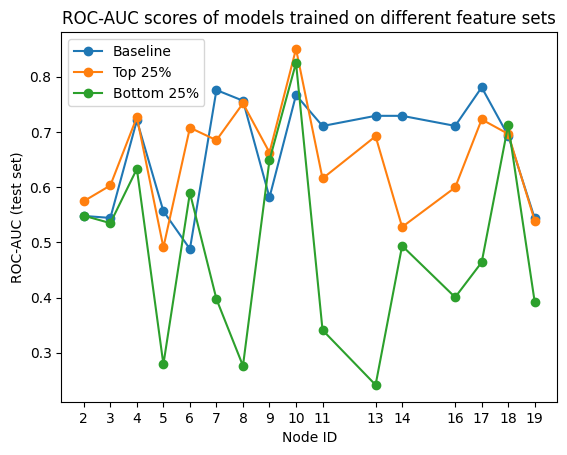

In [16]:
plt.title("ROC-AUC scores of models trained on different feature sets")
plt.plot(rack_0, [results_baseline[node] for node in rack_0], marker="o", label="Baseline")
plt.plot(rack_0, [results_top[node] for node in rack_0], marker="o", label="Top 25%")
plt.plot(rack_0, [results_bot[node] for node in rack_0], marker="o", label="Bottom 25%")
plt.xticks(rack_0)
plt.ylabel("ROC-AUC (test set)")
plt.xlabel("Node ID")
plt.legend()
plt.show()

## RUAD with random 25% features training

In [44]:
percent = 0.25

rand_features = np.random.choice([i for i in range(num_features)], int(num_features * percent)).tolist()
for node in rack_0:
    set_seed(seed)
    file_path = root_path / f"{node}.parquet"

    batch_collator_fn = partial(batch_collator, features_idx=rand_features)
    train_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="train", window_size=window_size)
    val_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="val", window_size=window_size)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator_fn,
        shuffle=True,
    )
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        collate_fn=batch_collator_fn,
    )
    model = RUADModule(RUAD(len(rand_features)), lr=lr, optimizer="adam")
    train(model, train_loader, val_loader, name=f"lr{lr}/RUAD_randfeatures0.25_{node}", num_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_2

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 376/376 [00:17<00:00, 21.83it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 376/376 [00:17<00:00, 21.82it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_3

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 98/98 [00:06<00:00, 14.65it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 98/98 [00:06<00:00, 14.63it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_4

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 153/153 [00:08<00:00, 18.77it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 153/153 [00:08<00:00, 18.76it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_5

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 154/154 [00:08<00:00, 18.57it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 154/154 [00:08<00:00, 18.56it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_6

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 160/160 [00:08<00:00, 18.79it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 160/160 [00:08<00:00, 18.77it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_7

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 436/436 [00:17<00:00, 25.36it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 436/436 [00:17<00:00, 25.35it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_8

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 436/436 [00:18<00:00, 23.91it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 436/436 [00:18<00:00, 23.89it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_9

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:21<00:00, 20.41it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:21<00:00, 20.40it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_10

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:20<00:00, 22.00it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:20<00:00, 21.99it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_11

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 441/441 [00:19<00:00, 22.12it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 441/441 [00:19<00:00, 22.11it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_13

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 439/439 [00:18<00:00, 24.03it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 439/439 [00:18<00:00, 24.02it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_14

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:21<00:00, 20.01it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:21<00:00, 19.99it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_16

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 429/429 [00:18<00:00, 22.67it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 429/429 [00:18<00:00, 22.64it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_17

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 437/437 [00:21<00:00, 20.28it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 437/437 [00:21<00:00, 20.25it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_18

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 393/393 [00:19<00:00, 20.30it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 393/393 [00:19<00:00, 20.29it/s, v_num=0]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: runs/lr0.0001/RUAD_randfeatures0.25_19

  | Name        | Type      | Params
------------------------------------------
0 | model       | RUAD      | 11.7 K
1 | loss_fn     | MSELoss   | 0     
2 | all_targets | CatMetric | 0     
3 | all_labels  | CatMetric | 0     
4 | all_preds   | CatMetric | 0     
------------------------------------------
11.7 K    Trainable params
0         Non-trainable params
11.7 K    Total params
0.047     Total estimated model params size (MB)


/home/prahtz/workspace/nlp-ad-m100/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 380/380 [00:15<00:00, 24.17it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 380/380 [00:15<00:00, 24.16it/s, v_num=0]


In [112]:
print(rand_features)

[102, 348, 270, 106, 71, 188, 20, 102, 121, 214, 330, 87, 99, 151, 130, 149, 308, 257, 343, 293, 191, 276, 160, 313, 21, 252, 235, 344, 48, 58, 169, 187, 270, 189, 174, 50, 54, 243, 319, 130, 306, 134, 20, 328, 166, 273, 88, 315, 13, 241, 264, 345, 52, 339, 91, 263, 34, 205, 80, 49, 1, 53, 105, 259, 309, 190, 217, 43, 161, 201, 269, 350, 303, 270, 214, 251, 189, 295, 212, 207, 236, 337, 52, 279, 216, 251, 187, 40]


In [19]:
trainer = L.Trainer()
results_rand = {}
for node in rack_0:
    file_path = root_path / f"{node}.parquet"
    test_dataset = TimeAggregatedNode(root_path=file_path, descriptions_path="descriptions.csv", split="test", window_size=window_size)
    batch_collator_fn = partial(batch_collator, features_idx=rand_features)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=batch_collator_fn)
    model = RUAD(len(rand_features))
    model_rand = RUADModule.load_from_checkpoint(
        f"runs/lr{lr}/RUAD_randfeatures0.25_{node}/version_0/checkpoints/best.ckpt", map_location="cpu", model=model, lr=lr
    )
    results_rand[node] = trainer.test(model_rand, test_loader, verbose=False)[0]["roc_auc"]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 111/111 [00:02<00:00, 40.11it/s]


In [22]:
avg_rand_roc_improvement = 0.0
for node in rack_0:
    avg_rand_roc_improvement += results_rand[node] - results_baseline[node]
avg_rand_roc_improvement /= len(rack_0)

print("Average ROC-AUC improvement using random 25% features:", avg_rand_roc_improvement)

Average ROC-AUC improvement using random 25% features: 0.0014416072517633438


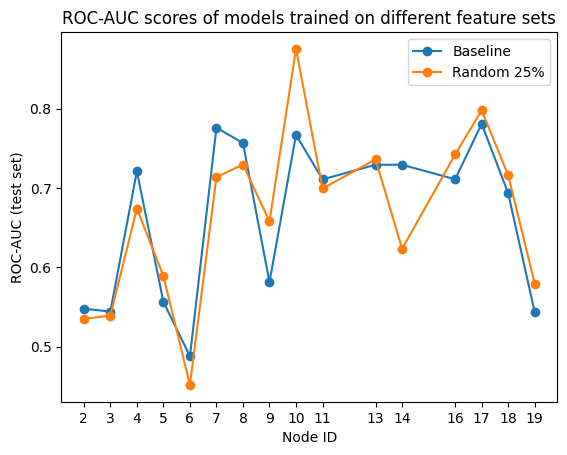

In [24]:
plt.title("ROC-AUC scores of models trained on different feature sets")
plt.plot(rack_0, [results_baseline[node] for node in rack_0], marker="o", label="Baseline")
plt.plot(rack_0, [results_rand[node] for node in rack_0], marker="o", label="Random 25%")
plt.xticks(rack_0)
plt.ylabel("ROC-AUC (test set)")
plt.xlabel("Node ID")
plt.legend()
plt.show()

# Conclusions
- Gating the features based on their description's embeddings did not show any significant improvement of the ROC-AUC score with respect to the baseline.
- When gating using softmax, we observed that the network learns to filter-out the features that are not hard/necessary to be reconstructed.
- When using a random 25% of the original feature set, we observed ROC-AUC scores similar to those fo the baselines
    - Could be interesting to invsetigate why this happens, and devise a method to choose the best feature set to improve the baselines.

# Bibliography

- [1] Borghesi, A. et al. M100 ExaData: a data collection campaign on the CINECA’s Marconi100 Tier-0 supercomputer. Scientific Data vol. 10 (2023).
- [2] Molan, M., Borghesi, A., Cesarini, D., Benini, L. & Bartolini, A. RUAD: Unsupervised anomaly detection in HPC systems. Future Generation Computer Systems vol. 141 542–554 (2023).
- [3] Wenhui Wang, Furu Wei, Li Dong, Hangbo Bao, Nan Yang, Ming Zhou: MiniLM: Deep Self-Attention Distillation for Task-Agnostic Compression of Pre-Trained Transformers. CoRR abs/2002.10957 (2020)
- [4] Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova: BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. NAACL-HLT (1) 2019: 4171-4186
- [5] John Edison Arevalo Ovalle, Thamar Solorio, Manuel Montes-y-Gómez, Fabio A. González: Gated Multimodal Units for Information Fusion. CoRR abs/1702.01992 (2017)